# Описание

Есть достаточно большой дата-сет, многолетний, по займам. 

Вам нужно предсказать бинарный таргет.

 

Оценка модели будет делаться по метрике Gini:

Gini = 2 * AUC - 1 где AUC - это ROC AUC.

Для построения модели, предоставляется обучающий набор клиентов X_train.csv с информацией о заемщиках. Целевая переменная находится в файле y_train.csv (1 = "невозврат")

Необходимо для каждого клиента из тестовой выборки test.csv предсказать loan_status, который равен 1, если займ не возвращен и 0, если заемщик вернул займ.

Результат должен быть представлен в виде упакованного в zip CSV-файла с названием answer.csv и с колонками index и loan_status (где проставлена вероятность значения 1):

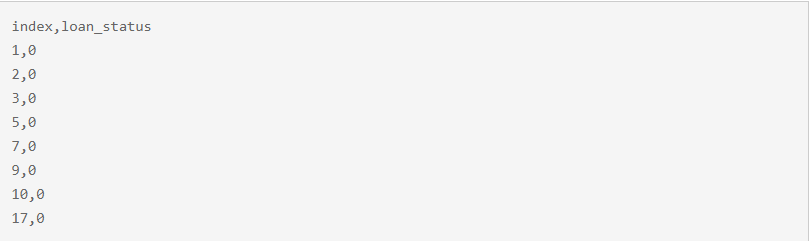

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
warnings.filterwarnings('ignore')

In [2]:
try:
    X_train = pd.read_csv('data/X_train.csv', index_col=0)
    X_test = pd.read_csv('data/X_test.csv', index_col=0)
    y_train = pd.read_csv('data/y_train.csv', index_col=0)
except:
    X_train = pd.read_csv('X_train.csv', index_col=0)
    X_test = pd.read_csv('X_test.csv', index_col=0)
    y_train = pd.read_csv('y_train.csv', index_col=0)
    
pd.set_option('display.max_columns', None)

# Предобработка данных

In [3]:
X_train.head()

,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,UT,80000.0,0.0,0.0,0.0,30.49,Oct-1996,4 years,689.0,685.0,16000.0,RENT,1.0,539.03,12.99%,Apr-2016,16000.0,5.0,50.0,65.0,6.0,3.0,4.0,17.0,14.0,0.0,0.0,0.0,3.0,14.0,2.0,3.0,100.0,1.0,1.0,credit_card,56.1%,0.0,36 months,Credit card refinancing,26.0,Source Verified,847xx
1,0.0,CA,82000.0,0.0,0.0,0.0,7.00,Mar-1993,10+ years,689.0,685.0,6600.0,MORTGAGE,0.0,214.27,10.42%,Sep-2017,6600.0,2.0,NaN,NaN,NaN,0.0,3.0,8.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,100.0,1.0,1.0,credit_card,88.3%,0.0,36 months,Credit card refinancing,11.0,Not Verified,900xx
2,0.0,NV,46080.0,0.0,0.0,1.0,17.32,Nov-2000,3 years,674.0,670.0,10000.0,MORTGAGE,0.0,317.96,8.99%,Aug-2016,10000.0,3.0,10.0,NaN,13.0,0.0,1.0,23.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,3.0,0.0,0.0,0.0,credit_card,18.1%,0.0,36 months,Credit card refinancing,31.0,Source Verified,895xx
3,0.0,AZ,30000.0,0.0,0.0,0.0,7.80,Jan-2010,< 1 year,694.0,690.0,3000.0,OWN,NaN,98.98,11.53%,Aug-2015,3000.0,0.0,NaN,NaN,16.0,0.0,3.0,11.0,19.0,0.0,0.0,0.0,4.0,19.0,NaN,NaN,0.0,0.0,0.0,car,33.4%,0.0,36 months,Car financing,24.0,Source Verified,853xx
4,0.0,OH,70000.0,0.0,0.0,0.0,13.36,Jan-2002,< 1 year,674.0,670.0,20000.0,RENT,0.0,602.37,26.30%,Sep-2017,20000.0,0.0,24.0,NaN,15.0,0.0,1.0,3.0,4.0,0.0,0.0,0.0,0.0,4.0,3.0,1.0,100.0,0.0,0.0,other,88.6%,0.0,60 months,Other,16.0,Not Verified,453xx


### Рассмотрим каждый признак

In [4]:
def feat_info(df, feature):
    print('-'*100)
    print(f'{feature.upper()}\n')
    print(f'Первые пять строк:\n{df[feature].head()}')
    print('-'*100)
    print(f'Описательная статистика:\n{df[feature].describe()}')
    print('-'*100)
    print(f'Количество уникальных значений:\n{df[feature].value_counts()}')
    print('-'*100)
    print(f'Количество пропусков:\n{df[feature].isna().sum()}')
    print('-'*100)
    try:
        df[feature].hist()
        plt.show()
    except:
        print('Не удалось построить график')
    print('-'*100)
    print('~'*100)

In [5]:
# множества для разбивки признаков
drop_features = set()
categorical_features = set()
numeric_features = set()

**acc_now_delinq**

----------------------------------------------------------------------------------------------------
ACC_NOW_DELINQ

Первые пять строк:
index
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: acc_now_delinq, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199861e+06
mean     4.625536e-03
std      7.284156e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.000000e+00
Name: acc_now_delinq, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0.0    1194659
1.0       4910
2.0        248
3.0         36
4.0          5
5.0          2
6.0          1
Name: acc_now_delinq, dtype: int64
----------------------------------------------------------------------------------------------------
Количество пропусков:
0
---------------------------------------

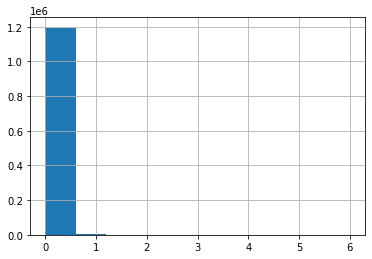

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [6]:
# acc_now_delinq - количество просрочек
feat_info(X_train, 'acc_now_delinq') 

In [7]:
# Кто имеет больше 1 просрочки не имееют особого веса для обучения и это количественный признак
# X_train = X_train[X_train['acc_now_delinq'] < 2]
numeric_features.add('acc_now_delinq')

**addr_state**

----------------------------------------------------------------------------------------------------
ADDR_STATE

Первые пять строк:
index
0    UT
1    CA
2    NV
3    AZ
4    OH
Name: addr_state, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     1199861
unique         51
top            CA
freq       171589
Name: addr_state, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
CA    171589
TX     98740
NY     98339
FL     86422
IL     46874
NJ     43768
PA     40457
OH     39434
GA     39418
NC     33717
VA     33538
MI     31504
AZ     29034
MD     28110
MA     27462
CO     25938
WA     25460
MN     21260
IN     19442
MO     18851
TN     18550
CT     18171
NV     17928
WI     15744
AL     14844
SC     14547
OR     14369
LA     13453
KY     11454
OK     10847
KS      9809
AR      8856
UT      859

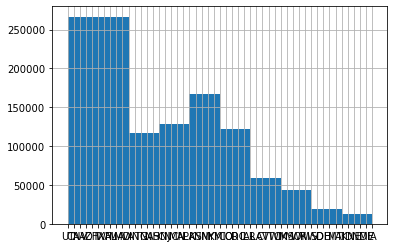

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [8]:
# addr_state - штат
feat_info(X_train, 'addr_state') 

In [9]:
# Штат не даст нам веса в обучении, его можно удалить
drop_features.add('addr_state')

**annual_inc**

----------------------------------------------------------------------------------------------------
ANNUAL_INC

Первые пять строк:
index
0    80000.0
1    82000.0
2    46080.0
3    30000.0
4    70000.0
Name: annual_inc, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199861e+06
mean     7.811051e+04
std      1.363514e+05
min      2.300000e+03
25%      4.700000e+04
50%      6.500000e+04
75%      9.300000e+04
max      1.100000e+08
Name: annual_inc, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
60000.00    46288
50000.00    40569
65000.00    34534
70000.00    33127
80000.00    31595
            ...  
88226.00        1
67626.00        1
43196.00        1
53912.00        1
34450.89        1
Name: annual_inc, Length: 59051, dtype: int64
----------------------------------------------------

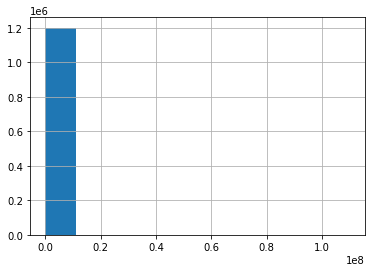

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [10]:
feat_info(X_train, 'annual_inc') 

In [11]:
# прибыль никуда не денется, количественный признак
numeric_features.add('annual_inc')

**chargeoff_within_12_mths**

----------------------------------------------------------------------------------------------------
CHARGEOFF_WITHIN_12_MTHS

Первые пять строк:
index
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: chargeoff_within_12_mths, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     8.901306e-03
std      1.081550e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+01
Name: chargeoff_within_12_mths, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0.0     1190259
1.0        8769
2.0         619
3.0         109
4.0          35
5.0          12
6.0          10
7.0           6
9.0           2
8.0           2
10.0          1
Name: chargeoff_within_12_mths, dtype: int64
-----------------------------------------------------

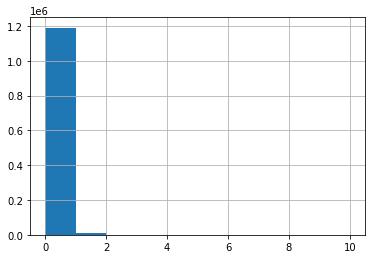

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [12]:
feat_info(X_train, 'chargeoff_within_12_mths') 

In [13]:
# избавимся от выбрасов и удалим пропуски из-за малого количесва
# X_train = X_train[X_train['chargeoff_within_12_mths'] < 2]
X_train = X_train.dropna(subset=['chargeoff_within_12_mths'])
numeric_features.add('chargeoff_within_12_mths')

**collections_12_mths_ex_med**

----------------------------------------------------------------------------------------------------
COLLECTIONS_12_MTHS_EX_MED

Первые пять строк:
index
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: collections_12_mths_ex_med, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     1.810182e-02
std      1.507312e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+01
Name: collections_12_mths_ex_med, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0.0     1179983
1.0       18394
2.0        1210
3.0         152
4.0          50
5.0          17
6.0           6
7.0           4
20.0          2
12.0          2
9.0           2
10.0          1
8.0           1
Name: collections_12_mths_ex_med, dtype: int64
-------------

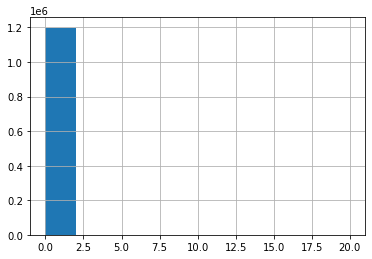

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [14]:
feat_info(X_train, 'collections_12_mths_ex_med') 

In [15]:
# так же уберем выбросы
# X_train = X_train[X_train['collections_12_mths_ex_med'] < 2]
numeric_features.add('collections_12_mths_ex_med')

**delinq_2yrs**

----------------------------------------------------------------------------------------------------
DELINQ_2YRS

Первые пять строк:
index
0    0.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: delinq_2yrs, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     3.142319e-01
std      8.763800e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.200000e+01
Name: delinq_2yrs, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0.0     971455
1.0     152036
2.0      44045
3.0      16219
4.0       7126
5.0       3617
6.0       2102
7.0       1171
8.0        688
9.0        444
10.0       288
11.0       189
12.0       140
13.0        86
14.0        76
15.0        46
16.0        23
17.0        18
18.0        15
19.0        14
20.0        1

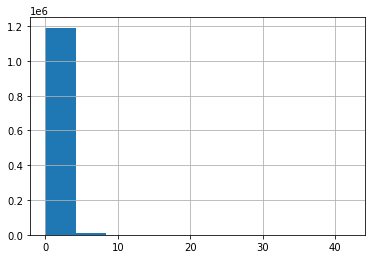

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [16]:
feat_info(X_train, 'delinq_2yrs') 

In [17]:
# просрочки немного причешем
# X_train = X_train[X_train['delinq_2yrs'] < 8]
numeric_features.add('delinq_2yrs')

**dti**

----------------------------------------------------------------------------------------------------
DTI

Первые пять строк:
index
0    30.49
1     7.00
2    17.32
3     7.80
4    13.36
Name: dti, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     1.803905e+01
std      8.404549e+00
min     -1.000000e+00
25%      1.174000e+01
50%      1.755000e+01
75%      2.397000e+01
max      4.996000e+01
Name: dti, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
19.20    892
16.80    863
14.40    839
18.00    836
15.60    815
        ... 
49.51      1
42.51      1
45.02      1
49.56      1
44.41      1
Name: dti, Length: 4747, dtype: int64
----------------------------------------------------------------------------------------------------
Количество пропусков:
0
---------------------

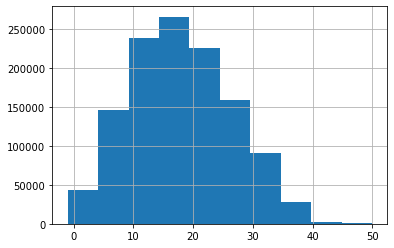

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [18]:
feat_info(X_train, 'dti') 

In [19]:
# отношения они такие, а какая нормаль
# X_train = X_train[X_train['dti'] < 39]
numeric_features.add('dti')

**earliest_cr_line**

----------------------------------------------------------------------------------------------------
EARLIEST_CR_LINE

Первые пять строк:
index
0    Oct-1996
1    Mar-1993
2    Nov-2000
3    Jan-2010
4    Jan-2002
Name: earliest_cr_line, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count      1199824
unique         748
top       Sep-2003
freq          8114
Name: earliest_cr_line, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
Sep-2003    8114
Sep-2004    8056
Aug-2001    7923
Aug-2002    7826
Aug-2003    7741
            ... 
Dec-1950       1
Feb-2017       1
Nov-1957       1
Oct-1957       1
Jul-1955       1
Name: earliest_cr_line, Length: 748, dtype: int64
----------------------------------------------------------------------------------------------------
Количество пропусков:
0
-------------

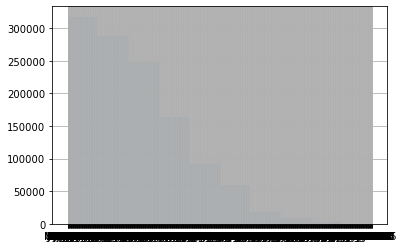

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [20]:
feat_info(X_train, 'earliest_cr_line') 

In [21]:
# важный признкак, как долго клиент в компании
X_train['time_in'] = (pd.Series([pd.to_datetime('2020-09-01') for i in range(X_train.shape[0])]) - \
pd.to_datetime(X_train['earliest_cr_line'])) / np.timedelta64 ( 1 , 'D')

In [22]:
X_train['time_in'] = X_train['time_in'].fillna(0)
drop_features.add('earliest_cr_line')
numeric_features.add('time_in')

**emp_length**

----------------------------------------------------------------------------------------------------
EMP_LENGTH

Первые пять строк:
index
0      4 years
1    10+ years
2      3 years
3     < 1 year
4     < 1 year
Name: emp_length, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count       1128077
unique           11
top       10+ years
freq         396909
Name: emp_length, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
10+ years    396909
2 years      109330
3 years       96811
< 1 year      94472
1 year        79953
5 years       75440
4 years       72996
6 years       55396
8 years       51576
7 years       51166
9 years       44028
Name: emp_length, dtype: int64
----------------------------------------------------------------------------------------------------
Количество пропусков:
71747
----

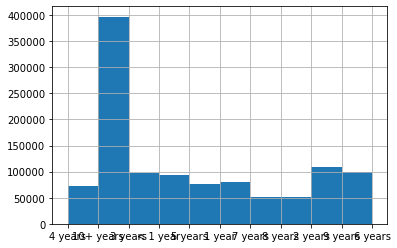

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [23]:
feat_info(X_train, 'emp_length') 

In [24]:
# заменим пропуски и избавимся от строк
X_train['emp_length'] = X_train['emp_length'].fillna('0')
X_train['emp_length'] = X_train['emp_length'].str.replace('< 1 year', '0')
X_train['emp_length'] = X_train['emp_length'].str.replace('[^0-9]+', '').astype('float')

In [25]:
numeric_features.add('emp_length')

**fico_range_high**

----------------------------------------------------------------------------------------------------
FICO_RANGE_HIGH

Первые пять строк:
index
0    689.0
1    689.0
2    674.0
3    694.0
4    674.0
Name: fico_range_high, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     7.011993e+02
std      3.234010e+01
min      6.640000e+02
25%      6.740000e+02
50%      6.940000e+02
75%      7.190000e+02
max      8.500000e+02
Name: fico_range_high, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
664.0    104274
674.0    101384
669.0    100855
679.0     90636
684.0     90548
689.0     79989
694.0     77683
699.0     69846
704.0     65110
709.0     59015
714.0     52432
719.0     46250
724.0     39954
729.0     32406
734.0     28114
739.0     22510
744.0     20348
749.0     16412
754

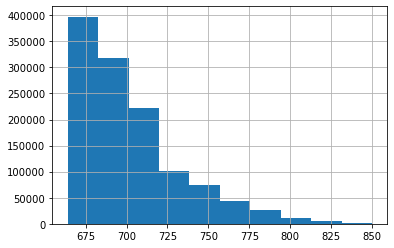

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [26]:
feat_info(X_train, 'fico_range_high') 

In [27]:
numeric_features.add('fico_range_high')

**fico_range_low**

----------------------------------------------------------------------------------------------------
FICO_RANGE_LOW

Первые пять строк:
index
0    685.0
1    685.0
2    670.0
3    690.0
4    670.0
Name: fico_range_low, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     6.971991e+02
std      3.233942e+01
min      6.600000e+02
25%      6.700000e+02
50%      6.900000e+02
75%      7.150000e+02
max      8.450000e+02
Name: fico_range_low, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
660.0    104274
670.0    101384
665.0    100855
675.0     90636
680.0     90548
685.0     79989
690.0     77683
695.0     69846
700.0     65110
705.0     59015
710.0     52432
715.0     46250
720.0     39954
725.0     32406
730.0     28114
735.0     22510
740.0     20348
745.0     16412
750.0 

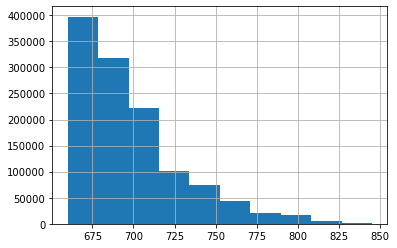

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [28]:
feat_info(X_train, 'fico_range_low') 

In [29]:
numeric_features.add('fico_range_low')

**funded_amnt**

----------------------------------------------------------------------------------------------------
FUNDED_AMNT

Первые пять строк:
index
0    16000.0
1     6600.0
2    10000.0
3     3000.0
4    20000.0
Name: funded_amnt, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     1.440491e+04
std      8.855210e+03
min      5.000000e+02
25%      7.675000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: funded_amnt, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
10000.0    94596
12000.0    64097
20000.0    63920
15000.0    63154
5000.0     46020
           ...  
725.0          1
950.0          1
38600.0        1
39875.0        1
36100.0        1
Name: funded_amnt, Length: 1562, dtype: int64
------------------------------------------------------------

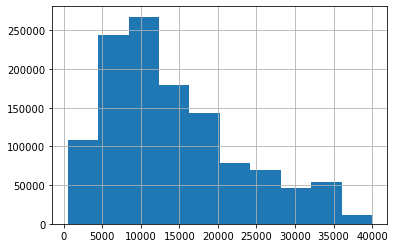

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [30]:
feat_info(X_train, 'funded_amnt') 

In [31]:
numeric_features.add('funded_amnt')

**home_ownership**

----------------------------------------------------------------------------------------------------
HOME_OWNERSHIP

Первые пять строк:
index
0        RENT
1    MORTGAGE
2    MORTGAGE
3         OWN
4        RENT
Name: home_ownership, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count      1199824
unique           6
top       MORTGAGE
freq        584268
Name: home_ownership, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
MORTGAGE    584268
RENT        481196
OWN         133423
ANY            817
OTHER           93
NONE            27
Name: home_ownership, dtype: int64
----------------------------------------------------------------------------------------------------
Количество пропусков:
0
----------------------------------------------------------------------------------------------------


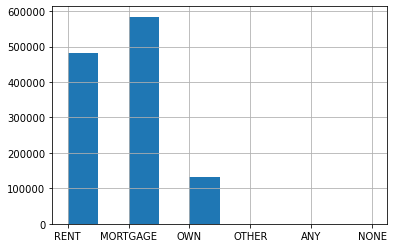

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [32]:
feat_info(X_train, 'home_ownership') 

In [33]:
X_train['home_ownership'] = X_train['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')
categorical_features.add('home_ownership')

**inq_last_12m**

----------------------------------------------------------------------------------------------------
INQ_LAST_12M

Первые пять строк:
index
0    1.0
1    0.0
2    0.0
3    NaN
4    0.0
Name: inq_last_12m, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    632646.000000
mean          2.180682
std           2.458328
min           0.000000
25%           0.000000
50%           2.000000
75%           3.000000
max          49.000000
Name: inq_last_12m, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0.0     164035
1.0     151569
2.0     111063
3.0      73983
4.0      47242
5.0      29800
6.0      18779
7.0      12015
8.0       7904
9.0       5154
10.0      3278
11.0      2316
12.0      1596
13.0      1069
14.0       765
15.0       549
16.0       412
17.0       271
18.0       216
19.0       166
20

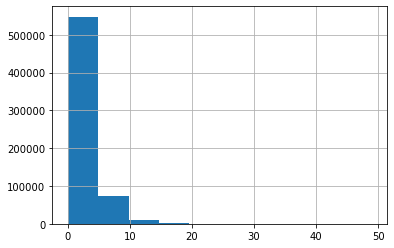

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [34]:
feat_info(X_train, 'inq_last_12m') 

In [35]:
# X_train = X_train[X_train['inq_last_12m'] < 14]
X_train['inq_last_12m'] = X_train['inq_last_12m'].fillna(0)
numeric_features.add('inq_last_12m')

**installment**

----------------------------------------------------------------------------------------------------
INSTALLMENT

Первые пять строк:
index
0    539.03
1    214.27
2    317.96
3     98.98
4    602.37
Name: installment, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     4.353275e+02
std      2.635840e+02
min      4.930000e+00
25%      2.446600e+02
50%      3.703700e+02
75%      5.767600e+02
max      1.719830e+03
Name: installment, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
301.15    2530
327.34    2246
332.10    2235
361.38    2028
451.73    1833
          ... 
983.71       1
97.59        1
481.31       1
420.79       1
370.58       1
Name: installment, Length: 81215, dtype: int64
--------------------------------------------------------------------------------------

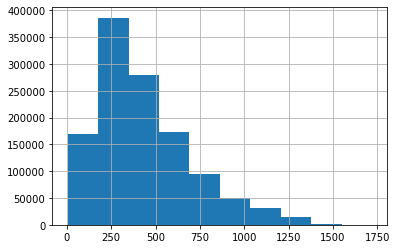

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [36]:
feat_info(X_train, 'installment') 

In [37]:
numeric_features.add('installment')

**int_rate**

----------------------------------------------------------------------------------------------------
INT_RATE

Первые пять строк:
index
0     12.99%
1     10.42%
2      8.99%
3     11.53%
4     26.30%
Name: int_rate, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     1199824
unique        668
top        10.99%
freq        28586
Name: int_rate, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
 10.99%    28586
 11.99%    27545
  5.32%    27417
 13.99%    25416
 11.49%    19940
           ...  
 17.50%        1
 15.13%        1
 19.16%        1
 17.44%        1
 15.38%        1
Name: int_rate, Length: 668, dtype: int64
----------------------------------------------------------------------------------------------------
Количество пропусков:
0
------------------------------------------------------

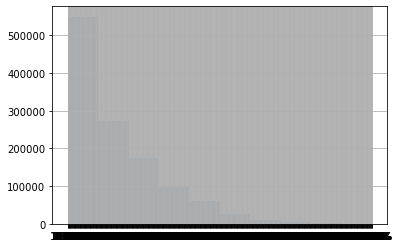

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [38]:
feat_info(X_train, 'int_rate')

In [39]:
X_train['int_rate'] = X_train['int_rate'].str.replace('%', '').astype('float')
numeric_features.add('int_rate')

**issue_d**

----------------------------------------------------------------------------------------------------
ISSUE_D

Первые пять строк:
index
0    Apr-2016
1    Sep-2017
2    Aug-2016
3    Aug-2015
4    Sep-2017
Name: issue_d, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count      1199824
unique         158
top       Mar-2016
freq         37886
Name: issue_d, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
Mar-2016    37886
Oct-2015    30274
Jul-2015    29208
Dec-2015    27642
Oct-2014    26010
            ...  
Oct-2007       29
Nov-2007       26
Sep-2008       17
Sep-2007       11
Aug-2007        6
Name: issue_d, Length: 158, dtype: int64
----------------------------------------------------------------------------------------------------
Количество пропусков:
0
--------------------------------------

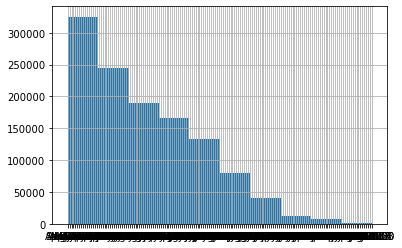

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [40]:
feat_info(X_train, 'issue_d') 

In [41]:
drop_features.add('issue_d')

**loan_amnt**

----------------------------------------------------------------------------------------------------
LOAN_AMNT

Первые пять строк:
index
0    16000.0
1     6600.0
2    10000.0
3     3000.0
4    20000.0
Name: loan_amnt, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     1.441115e+04
std      8.858025e+03
min      5.000000e+02
25%      7.700000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
10000.0    94654
12000.0    64162
20000.0    64045
15000.0    63232
5000.0     46026
           ...  
39875.0        1
38625.0        1
38775.0        1
38600.0        1
36100.0        1
Name: loan_amnt, Length: 1562, dtype: int64
--------------------------------------------------------------------

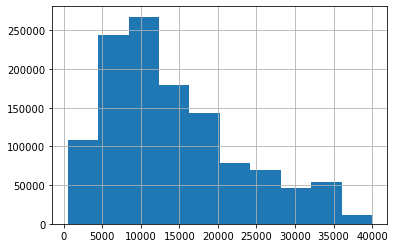

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [42]:
feat_info(X_train, 'loan_amnt') 

In [43]:
numeric_features.add('loan_amnt')

**mort_acc**

----------------------------------------------------------------------------------------------------
MORT_ACC

Первые пять строк:
index
0    5.0
1    2.0
2    3.0
3    0.0
4    0.0
Name: mort_acc, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.168320e+06
mean     1.598304e+00
std      1.948998e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      6.100000e+01
Name: mort_acc, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0.0     486698
1.0     204887
2.0     170009
3.0     122486
4.0      81246
5.0      48355
6.0      26732
7.0      13676
8.0       6739
9.0       3450
10.0      1772
11.0       944
12.0       485
13.0       268
14.0       196
15.0       103
16.0        73
17.0        45
18.0        33
19.0        24
20.0        22
24.0   

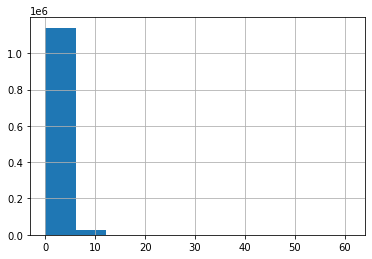

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [44]:
feat_info(X_train, 'mort_acc') 

In [45]:
# X_train = X_train[X_train['mort_acc'] < 10]
numeric_features.add('mort_acc')

**mths_since_last_delinq**

----------------------------------------------------------------------------------------------------
MTHS_SINCE_LAST_DELINQ

Первые пять строк:
index
0    50.0
1     NaN
2    10.0
3     NaN
4    24.0
Name: mths_since_last_delinq, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    592384.000000
mean         34.421650
std          21.883333
min           0.000000
25%          16.000000
50%          31.000000
75%          50.000000
max         226.000000
Name: mths_since_last_delinq, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
12.0     11204
6.0      11180
13.0     11179
9.0      10985
7.0      10952
         ...  
127.0        1
151.0        1
162.0        1
226.0        1
153.0        1
Name: mths_since_last_delinq, Length: 167, dtype: int64
----------------------------------------------

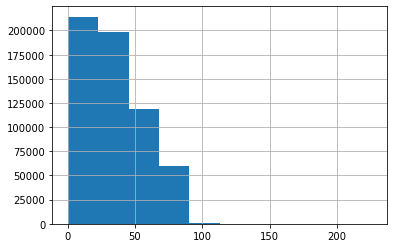

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [46]:
feat_info(X_train, 'mths_since_last_delinq') 

In [47]:
# X_train = X_train[X_train['mths_since_last_delinq'] < 100]
X_train['mths_since_last_delinq'] = X_train['mths_since_last_delinq'].fillna(0)
numeric_features.add('mths_since_last_delinq')

**mths_since_recent_bc_dlq**

----------------------------------------------------------------------------------------------------
MTHS_SINCE_RECENT_BC_DLQ

Первые пять строк:
index
0    65.0
1     NaN
2     NaN
3     NaN
4     NaN
Name: mths_since_recent_bc_dlq, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    282665.000000
mean         39.439258
std          22.645351
min           0.000000
25%          21.000000
50%          37.000000
75%          58.000000
max         198.000000
Name: mths_since_recent_bc_dlq, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
25.0     4360
26.0     4341
28.0     4304
19.0     4240
29.0     4235
         ... 
157.0       1
198.0       1
143.0       1
151.0       1
161.0       1
Name: mths_since_recent_bc_dlq, Length: 168, dtype: int64
-------------------------------------------------

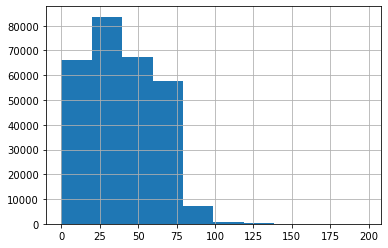

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [48]:
feat_info(X_train, 'mths_since_recent_bc_dlq') 

In [49]:
# X_train = X_train[X_train['mths_since_recent_bc_dlq'] < 100]
X_train['mths_since_recent_bc_dlq'] = X_train['mths_since_recent_bc_dlq'].fillna(0)
numeric_features.add('mths_since_recent_bc_dlq')

**mths_since_recent_inq**

----------------------------------------------------------------------------------------------------
MTHS_SINCE_RECENT_INQ

Первые пять строк:
index
0     6.0
1     NaN
2    13.0
3    16.0
4    15.0
Name: mths_since_recent_inq, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.050080e+06
mean     6.827069e+00
std      5.884748e+00
min      0.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.000000e+01
max      2.500000e+01
Name: mths_since_recent_inq, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
1.0     118139
2.0      94864
0.0      93697
3.0      86089
4.0      78176
5.0      69042
6.0      62004
7.0      58430
8.0      51535
9.0      45085
10.0     39419
11.0     35200
12.0     31642
13.0     28308
14.0     25036
15.0     21634
16.0     19045
17.0     17007
18.0    

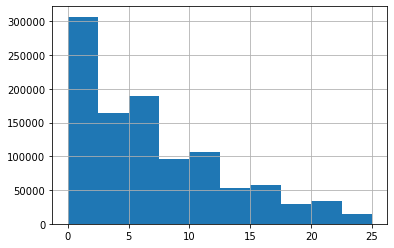

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [50]:
feat_info(X_train, 'mths_since_recent_inq')

In [51]:
# X_train = X_train[X_train['mths_since_recent_inq'] < 25]
X_train['mths_since_recent_inq'] = X_train['mths_since_recent_inq'].fillna(0)
numeric_features.add('mths_since_recent_inq')

**num_accts_ever_120_pd**

----------------------------------------------------------------------------------------------------
NUM_ACCTS_EVER_120_PD

Первые пять строк:
index
0    3.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: num_accts_ever_120_pd, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.154852e+06
mean     5.125202e-01
std      1.354282e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.100000e+01
Name: num_accts_ever_120_pd, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0.0     883335
1.0     144907
2.0      57473
3.0      26485
4.0      15713
5.0       9370
6.0       6073
7.0       3858
8.0       2452
9.0       1633
10.0      1132
11.0       676
12.0       526
13.0       287
14.0       275
15.0       155
16.0       116
17.0        76
18.0        6

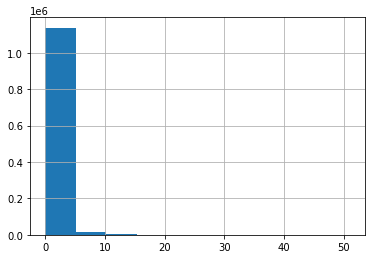

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [52]:
feat_info(X_train, 'num_accts_ever_120_pd')

In [53]:
# X_train = X_train[X_train['num_accts_ever_120_pd'] < 11]
numeric_features.add('num_accts_ever_120_pd')

**num_actv_bc_tl**

----------------------------------------------------------------------------------------------------
NUM_ACTV_BC_TL

Первые пять строк:
index
0    4.0
1    3.0
2    1.0
3    3.0
4    1.0
Name: num_actv_bc_tl, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.154852e+06
mean     3.655532e+00
std      2.285259e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      5.000000e+01
Name: num_actv_bc_tl, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
3.0     245180
2.0     235160
4.0     190042
1.0     134170
5.0     127164
6.0      79592
7.0      47434
8.0      28385
0.0      25353
9.0      16928
10.0      9829
11.0      6035
12.0      3644
13.0      2229
14.0      1272
15.0       874
16.0       492
17.0       372
18.0       237
19.0       154
20.0

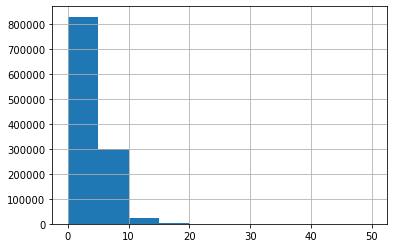

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [54]:
feat_info(X_train, 'num_actv_bc_tl')

In [55]:
# X_train = X_train[X_train['num_actv_bc_tl'] < 15]
numeric_features.add('num_actv_bc_tl')

**num_rev_accts**

----------------------------------------------------------------------------------------------------
NUM_REV_ACCTS

Первые пять строк:
index
0    17.0
1     8.0
2    23.0
3    11.0
4     3.0
Name: num_rev_accts, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.154851e+06
mean     1.432988e+01
std      8.117148e+00
min      0.000000e+00
25%      8.000000e+00
50%      1.300000e+01
75%      1.800000e+01
max      1.280000e+02
Name: num_rev_accts, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
10.0     69015
9.0      68212
11.0     67623
8.0      65706
12.0     65225
         ...  
127.0        1
101.0        1
104.0        1
112.0        1
117.0        1
Name: num_rev_accts, Length: 111, dtype: int64
------------------------------------------------------------------------------------------

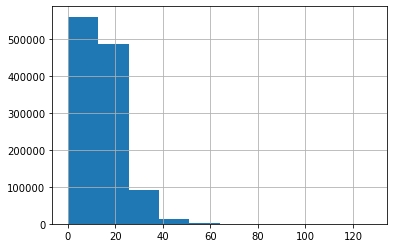

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [56]:
feat_info(X_train, 'num_rev_accts')

In [57]:
# X_train = X_train[X_train['num_rev_accts'] < 60]
numeric_features.add('num_rev_accts')

**num_sats**

----------------------------------------------------------------------------------------------------
NUM_SATS

Первые пять строк:
index
0    14.0
1     5.0
2     7.0
3    19.0
4     4.0
Name: num_sats, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.162566e+06
mean     1.164593e+01
std      5.580223e+00
min      0.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.400000e+01
max      9.000000e+01
Name: num_sats, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
9.0     101919
10.0     98880
8.0      98313
11.0     91449
7.0      88568
         ...  
77.0         1
68.0         1
81.0         1
78.0         1
87.0         1
Name: num_sats, Length: 83, dtype: int64
----------------------------------------------------------------------------------------------------
Количество

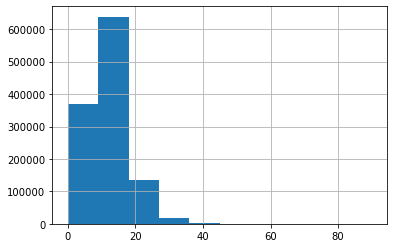

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [58]:
feat_info(X_train, 'num_sats')

In [59]:
# X_train = X_train[X_train['num_sats'] < 40]
numeric_features.add('num_sats')

**num_tl_120dpd_2m**

----------------------------------------------------------------------------------------------------
NUM_TL_120DPD_2M

Первые пять строк:
index
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: num_tl_120dpd_2m, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.109253e+06
mean     7.221076e-04
std      2.877438e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.000000e+00
Name: num_tl_120dpd_2m, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0.0    1108495
1.0        724
2.0         29
3.0          3
4.0          1
6.0          1
Name: num_tl_120dpd_2m, dtype: int64
----------------------------------------------------------------------------------------------------
Количество пропусков:
90571
------------------------------------------

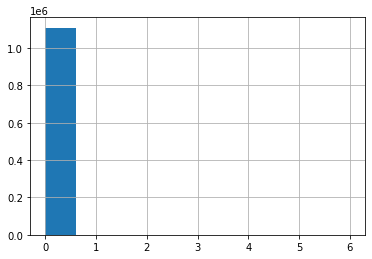

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [60]:
feat_info(X_train, 'num_tl_120dpd_2m')

In [61]:
X_train['num_tl_120dpd_2m'] = X_train['num_tl_120dpd_2m'].fillna(0)
numeric_features.add('num_tl_120dpd_2m')

**num_tl_30dpd**

----------------------------------------------------------------------------------------------------
NUM_TL_30DPD

Первые пять строк:
index
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: num_tl_30dpd, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.154852e+06
mean     3.144992e-03
std      5.954449e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.000000e+00
Name: num_tl_30dpd, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0.0    1151425
1.0       3251
2.0        150
3.0         23
4.0          3
Name: num_tl_30dpd, dtype: int64
----------------------------------------------------------------------------------------------------
Количество пропусков:
44972
-------------------------------------------------------------------------

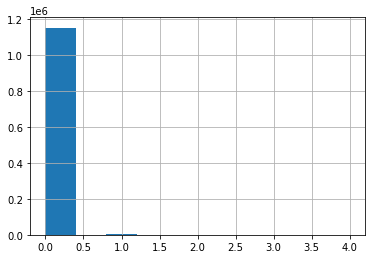

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [62]:
feat_info(X_train, 'num_tl_30dpd')

In [63]:
numeric_features.add('num_tl_30dpd')

**num_tl_90g_dpd_24m**

----------------------------------------------------------------------------------------------------
NUM_TL_90G_DPD_24M

Первые пять строк:
index
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: num_tl_90g_dpd_24m, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.154852e+06
mean     8.669682e-02
std      5.024471e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.200000e+01
Name: num_tl_90g_dpd_24m, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0.0     1090514
1.0       48172
2.0        9495
3.0        2622
4.0        1428
5.0         776
6.0         594
7.0         345
8.0         268
9.0         192
10.0        124
11.0         87
12.0         66
13.0         47
14.0         41
15.0         28
16.0         11
20.0          9
17.0

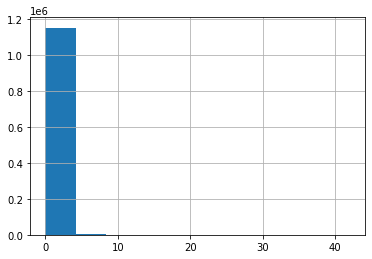

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [64]:
feat_info(X_train, 'num_tl_90g_dpd_24m')

In [65]:
# X_train = X_train[X_train['num_tl_90g_dpd_24m'] < 3]
numeric_features.add('num_tl_90g_dpd_24m')

**num_tl_op_past_12m**

----------------------------------------------------------------------------------------------------
NUM_TL_OP_PAST_12M

Первые пять строк:
index
0    3.0
1    0.0
2    0.0
3    4.0
4    0.0
Name: num_tl_op_past_12m, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.154852e+06
mean     2.156888e+00
std      1.853938e+00
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      3.200000e+01
Name: num_tl_op_past_12m, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
1.0     287845
2.0     259067
0.0     201656
3.0     184325
4.0     108815
5.0      54414
6.0      26999
7.0      14650
8.0       7554
9.0       4135
10.0      2245
11.0      1219
12.0       742
13.0       429
14.0       279
15.0       157
16.0       124
17.0        72
18.0        30
19.0   

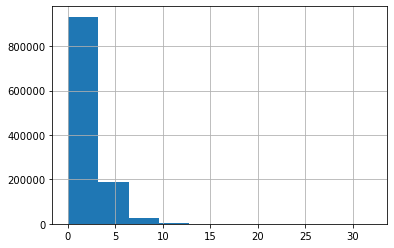

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [66]:
feat_info(X_train, 'num_tl_op_past_12m')

In [67]:
# X_train = X_train[X_train['num_tl_op_past_12m'] < 10]
numeric_features.add('num_tl_op_past_12m')

**open_acc**

----------------------------------------------------------------------------------------------------
OPEN_ACC

Первые пять строк:
index
0    14.0
1     5.0
2     7.0
3    19.0
4     4.0
Name: open_acc, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     1.162013e+01
std      5.574747e+00
min      0.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.400000e+01
max      9.000000e+01
Name: open_acc, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
9.0     105173
10.0    101920
8.0     101380
11.0     94237
7.0      91777
         ...  
70.0         1
77.0         1
71.0         1
90.0         1
88.0         1
Name: open_acc, Length: 83, dtype: int64
----------------------------------------------------------------------------------------------------
Количество

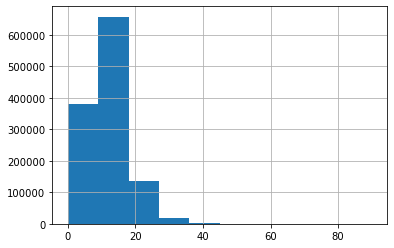

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [68]:
feat_info(X_train, 'open_acc')

In [69]:
numeric_features.add('open_acc')

**open_il_24m**

----------------------------------------------------------------------------------------------------
OPEN_IL_24M

Первые пять строк:
index
0    2.0
1    0.0
2    0.0
3    NaN
4    3.0
Name: open_il_24m, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    632647.000000
mean          1.677463
std           1.641795
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          39.000000
Name: open_il_24m, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
1.0     195526
0.0     155476
2.0     133866
3.0      72723
4.0      36846
5.0      18818
6.0       9270
7.0       4769
8.0       2520
9.0       1247
10.0       720
11.0       378
12.0       219
13.0       122
14.0        62
15.0        25
16.0        18
17.0        10
20.0         7
18.0         7
19.0 

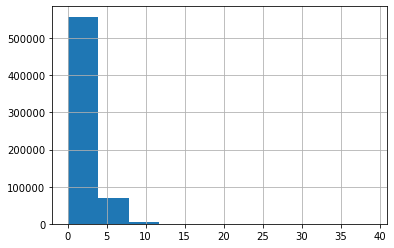

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [70]:
feat_info(X_train, 'open_il_24m')

In [71]:
# X_train = X_train[X_train['open_il_24m'] < 8]
numeric_features.add('open_il_24m')

**open_rv_24m**

----------------------------------------------------------------------------------------------------
OPEN_RV_24M

Первые пять строк:
index
0    3.0
1    1.0
2    3.0
3    NaN
4    1.0
Name: open_rv_24m, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    632647.000000
mean          2.899328
std           2.667496
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          54.000000
Name: open_rv_24m, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
1.0     128900
2.0     120478
3.0      93807
0.0      91678
4.0      66371
5.0      45160
6.0      29431
7.0      19642
8.0      12453
9.0       8149
10.0      5352
11.0      3545
12.0      2241
13.0      1651
14.0      1156
15.0       656
16.0       543
17.0       383
18.0       269
19.0       197
20.0 

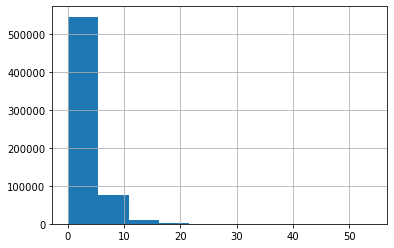

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [72]:
feat_info(X_train, 'open_rv_24m')

In [73]:
# X_train = X_train[X_train['open_rv_24m'] < 11]
numeric_features.add('open_rv_24m')

**percent_bc_gt_75**

----------------------------------------------------------------------------------------------------
PERCENT_BC_GT_75

Первые пять строк:
index
0    100.0
1    100.0
2      0.0
3      0.0
4    100.0
Name: percent_bc_gt_75, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.155527e+06
mean     4.318438e+01
std      3.613864e+01
min      0.000000e+00
25%      0.000000e+00
50%      4.000000e+01
75%      7.500000e+01
max      1.000000e+02
Name: percent_bc_gt_75, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0.0      305268
100.0    200288
50.0     124895
33.3      78966
66.7      73174
          ...  
44.8          1
48.1          1
36.7          1
2.2           1
76.2          1
Name: percent_bc_gt_75, Length: 251, dtype: int64
--------------------------------------------------------------

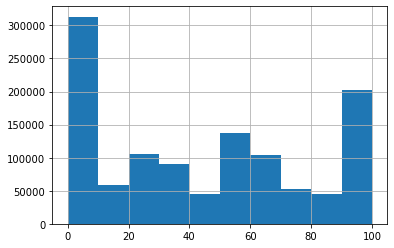

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [74]:
feat_info(X_train, 'percent_bc_gt_75')

In [75]:
X_train['percent_bc_gt_75'] = X_train['percent_bc_gt_75'].fillna(0)
numeric_features.add('percent_bc_gt_75')

**pub_rec**

----------------------------------------------------------------------------------------------------
PUB_REC

Первые пять строк:
index
0    1.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: pub_rec, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     2.097391e-01
std      5.909505e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.600000e+01
Name: pub_rec, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0.0     1000690
1.0      167886
2.0       20400
3.0        6271
4.0        2281
5.0        1091
6.0         549
7.0         257
8.0         140
9.0          79
10.0         52
11.0         39
12.0         22
13.0         14
15.0          8
14.0          7
21.0          5
28.0          4
19.0          4
18.0          3
22.0 

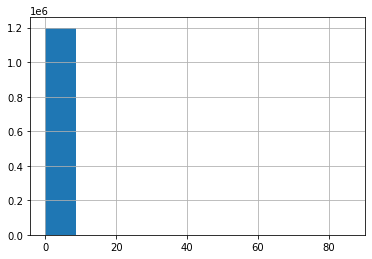

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [76]:
feat_info(X_train, 'pub_rec')

In [77]:
# X_train = X_train[X_train['pub_rec'] < 3]
numeric_features.add('pub_rec')

**pub_rec_bankruptcies**

----------------------------------------------------------------------------------------------------
PUB_REC_BANKRUPTCIES

Первые пять строк:
index
0    1.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: pub_rec_bankruptcies, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199392e+06
mean     1.326222e-01
std      3.732349e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.200000e+01
Name: pub_rec_bankruptcies, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0.0     1051100
1.0      140093
2.0        6404
3.0        1286
4.0         330
5.0         123
6.0          35
7.0          12
8.0           6
9.0           2
12.0          1
Name: pub_rec_bankruptcies, dtype: int64
---------------------------------------------------------------------

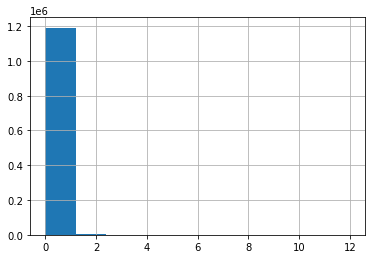

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [78]:
feat_info(X_train, 'pub_rec_bankruptcies')

In [79]:
numeric_features.add('pub_rec_bankruptcies')

**purpose**

----------------------------------------------------------------------------------------------------
PURPOSE

Первые пять строк:
index
0    credit_card
1    credit_card
2    credit_card
3            car
4          other
Name: purpose, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count                1199824
unique                    14
top       debt_consolidation
freq                  684517
Name: purpose, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
debt_consolidation    684517
credit_card           268411
home_improvement       78964
other                  73214
major_purchase         26885
medical                14327
small_business         13458
car                    13213
vacation                8684
moving                  8422
house                   7142
wedding                 1555

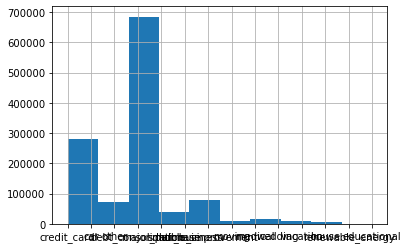

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [80]:
feat_info(X_train, 'purpose')

In [81]:
categorical_features.add('purpose')

**revol_util**

----------------------------------------------------------------------------------------------------
REVOL_UTIL

Первые пять строк:
index
0    56.1%
1    88.3%
2    18.1%
3    33.4%
4    88.6%
Name: revol_util, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     1198983
unique       1316
top            0%
freq         6611
Name: revol_util, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0%        6611
57%       2356
48%       2342
58%       2318
59%       2309
          ... 
28.41%       1
117.9%       1
0.49%        1
119.1%       1
154.3%       1
Name: revol_util, Length: 1316, dtype: int64
----------------------------------------------------------------------------------------------------
Количество пропусков:
841
---------------------------------------------------------------------------

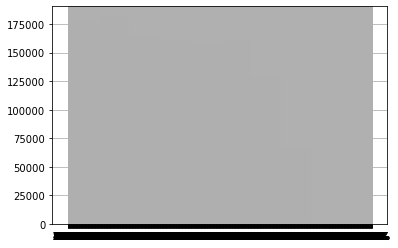

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [82]:
feat_info(X_train, 'revol_util')

In [83]:
X_train['revol_util'] = X_train['revol_util'].str.replace('%', '').astype('float')
X_train['revol_util'] = X_train['revol_util'].fillna(X_train['revol_util'].median())
numeric_features.add('revol_util')

**tax_liens**

In [84]:
X_train['revol_util'].unique()

array([ 56.1 ,  88.3 ,  18.1 , ..., 130.2 ,   8.01, 154.3 ])

----------------------------------------------------------------------------------------------------
TAX_LIENS

Первые пять строк:
index
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: tax_liens, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     5.066243e-02
std      3.914051e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.500000e+01
Name: tax_liens, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0.0     1162613
1.0       25221
2.0        6918
3.0        2535
4.0        1170
5.0         610
6.0         311
7.0         154
8.0          89
9.0          56
10.0         43
11.0         29
12.0         18
13.0          7
15.0          7
14.0          7
21.0          5
17.0          4
18.0          4
20.0          3

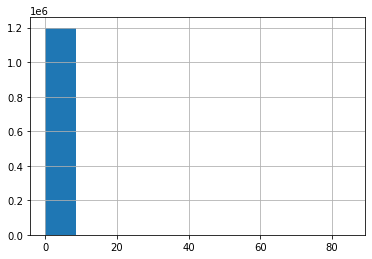

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [85]:
feat_info(X_train, 'tax_liens')

In [86]:
numeric_features.add('tax_liens')

**term**

----------------------------------------------------------------------------------------------------
TERM

Первые пять строк:
index
0     36 months
1     36 months
2     36 months
3     36 months
4     60 months
Name: term, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count        1199824
unique             2
top        36 months
freq          903662
Name: term, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
 36 months    903662
 60 months    296162
Name: term, dtype: int64
----------------------------------------------------------------------------------------------------
Количество пропусков:
0
----------------------------------------------------------------------------------------------------


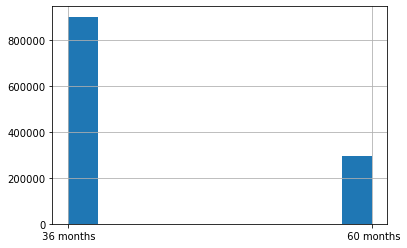

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [87]:
feat_info(X_train, 'term')

In [88]:
X_train['term'] = X_train['term'].str.replace('[^0-9]+', '').astype('float')

**title**

In [89]:
feat_info(X_train, 'title')

----------------------------------------------------------------------------------------------------
TITLE

Первые пять строк:
index
0    Credit card refinancing
1    Credit card refinancing
2    Credit card refinancing
3              Car financing
4                      Other
Name: title, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count                1186024
unique                 43831
top       Debt consolidation
freq                  602886
Name: title, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
Debt consolidation               602886
Credit card refinancing          237337
Home improvement                  70534
Other                             65688
Major purchase                    23260
                                  ...  
36 months to a less stress me         1
billpayoffqui

ValueError: 
$$ to Cents
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 432x288 with 1 Axes>

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [90]:
drop_features.add('title')

**total_acc**

----------------------------------------------------------------------------------------------------
TOTAL_ACC

Первые пять строк:
index
0    26.0
1    11.0
2    31.0
3    24.0
4    16.0
Name: total_acc, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     2.464254e+01
std      1.205225e+01
min      2.000000e+00
25%      1.600000e+01
50%      2.300000e+01
75%      3.100000e+01
max      1.730000e+02
Name: total_acc, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
20.0     43733
21.0     43191
19.0     43069
18.0     42875
22.0     42416
         ...  
173.0        1
141.0        1
135.0        1
157.0        1
117.0        1
Name: total_acc, Length: 142, dtype: int64
----------------------------------------------------------------------------------------------------
Колич

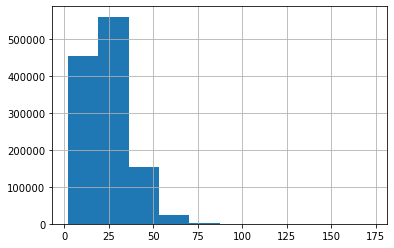

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [91]:
feat_info(X_train, 'total_acc')

In [92]:
# X_train = X_train[X_train['total_acc'] < 75]
numeric_features.add('total_acc')

**verification_status**

----------------------------------------------------------------------------------------------------
VERIFICATION_STATUS

Первые пять строк:
index
0    Source Verified
1       Not Verified
2    Source Verified
3    Source Verified
4       Not Verified
Name: verification_status, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count             1199824
unique                  3
top       Source Verified
freq               478709
Name: verification_status, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
Source Verified    478709
Not Verified       377096
Verified           344019
Name: verification_status, dtype: int64
----------------------------------------------------------------------------------------------------
Количество пропусков:
0
------------------------------------------------------------

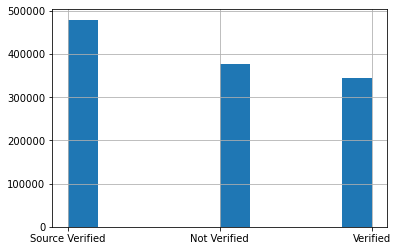

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [93]:
feat_info(X_train, 'verification_status')

In [94]:
X_train['verification_status'] = X_train['verification_status'].str.replace('Source Verified', 'Verified')
categorical_features.add('verification_status')

**zip_code**

----------------------------------------------------------------------------------------------------
ZIP_CODE

Первые пять строк:
index
0    847xx
1    900xx
2    895xx
3    853xx
4    453xx
Name: zip_code, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     1199823
unique        936
top         945xx
freq        12979
Name: zip_code, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
945xx    12979
750xx    12823
112xx    12605
606xx    11289
300xx    11150
         ...  
513xx        1
528xx        1
521xx        1
205xx        1
516xx        1
Name: zip_code, Length: 936, dtype: int64
----------------------------------------------------------------------------------------------------
Количество пропусков:
1
--------------------------------------------------------------------------------------

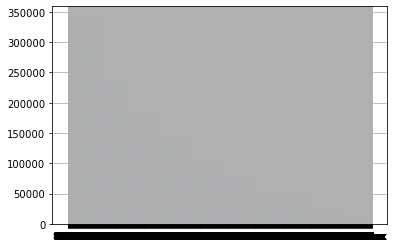

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [95]:
feat_info(X_train, 'zip_code')

In [96]:
drop_features.add('zip_code')

**чистим**

In [97]:
X_train = X_train.drop(columns=drop_features)

In [98]:
# тест тоже причешем
X_test['time_in'] = (pd.Series([pd.to_datetime('2020-09-01') for i in range(X_test.shape[0])]) - \
pd.to_datetime(X_test['earliest_cr_line'])) / np.timedelta64 ( 1 , 'D')

X_test['emp_length'] = X_test['emp_length'].str.replace('< 1 year', '0')
X_test['emp_length'] = X_test['emp_length'].str.replace('[^0-9]+', '').astype('float')

X_test['home_ownership'] = X_test['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')

X_test['int_rate'] = X_test['int_rate'].str.replace('%', '').astype('float')

X_test['revol_util'] = X_test['revol_util'].str.replace('%', '').astype('float')

X_test['term'] = X_test['term'].str.replace('[^0-9]+', '').astype('float')

X_test['verification_status'] = X_test['verification_status'].str.replace('Source Verified', 'Verified')

In [99]:
X_test = X_test.drop(columns=drop_features)

**кодируем**

In [100]:
categorical_features = list(categorical_features)
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_train[categorical_features])
X_train[categorical_features] = ordinal_encoder.transform(X_train[categorical_features]).astype('float')
X_test[categorical_features] = ordinal_encoder.transform(X_test[categorical_features]).astype('float')

**масштабируем**

In [101]:
numeric_features = list(numeric_features)
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

**Немного магии, чтобы все не полетело**

In [102]:
train = X_train.merge(y_train, left_index=True, right_index=True, how='left')

In [103]:
X_train = train.drop('loan_status', axis=1)
y_train = train['loan_status']

In [104]:
X_train = X_train.astype('float32')

# Обучение

In [105]:
param_grid = {
      'n_estimators': range(100,1000,100),
      'max_depth': range(1,11)}

In [106]:
%%time
estimator = CatBoostClassifier(random_state=0, 
                               verbose = False, 
                               auto_class_weights = 'Balanced')

model_cbc = RandomizedSearchCV(estimator, 
                               param_grid, 
                               verbose = False, 
                               n_jobs=-1,
                               scoring='roc_auc', 
                               random_state=0)

model_cbc.fit(X_train, y_train)

parametrs_cbc = model_cbc.best_params_
best_model_cbc = model_cbc.best_estimator_
print(f'ROC-AUC : {model_cbc.best_score_}')
print(f'Параметры : {parametrs_cbc}')

ROC-AUC : 0.7215047418773327
Параметры : {'n_estimators': 800, 'max_depth': 5}
Wall time: 34min 31s


In [107]:
%%time
estimator = LGBMClassifier(random_state=0, 
                                   class_weight = 'balanced')

model_lgbm = RandomizedSearchCV(estimator, 
                               param_grid, 
                               verbose = False, 
                               n_jobs=-1,
                               scoring='roc_auc', 
                               random_state=0)

model_lgbm.fit(X_train, y_train)

parametrs_lgbm = model_lgbm.best_params_
best_model_lgbm = model_lgbm.best_estimator_
print(f'ROC-AUC : {model_lgbm.best_score_}')
print(f'Параметры : {parametrs_lgbm}')

ROC-AUC : 0.7216807325483627
Параметры : {'n_estimators': 600, 'max_depth': 5}
Wall time: 6min 44s


----------------------------------------------------------------------------------------------------
ACC_NOW_DELINQ

Первые пять строк:
index
0   -0.063502
1   -0.063502
2   -0.063502
3   -0.063502
4   -0.063502
Name: acc_now_delinq, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     7.299021e-06
std      9.983426e-01
min     -6.350234e-02
25%     -6.350234e-02
50%     -6.350234e-02
75%     -6.350234e-02
max      8.230582e+01
Name: acc_now_delinq, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.063502     1194622
 13.664720       4910
 27.392941        248
 41.121162         36
 54.849384          5
 68.577606          2
 82.305824          1
Name: acc_now_delinq, dtype: int64
------------------------------------------------------------------------------------------

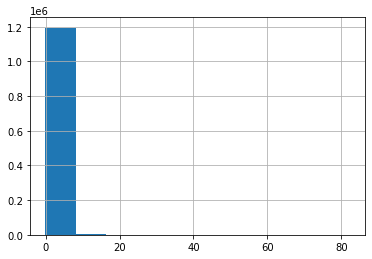

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
ANNUAL_INC

Первые пять строк:
index
0    0.013858
1    0.028526
2   -0.234908
3   -0.352837
4   -0.059481
Name: annual_inc, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     1.725410e-09
std      9.991289e-01
min     -5.559860e-01
25%     -2.281604e-01
50%     -9.615014e-02
75%      1.091992e-01
max      8.061567e+02
Name: annual_inc, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.132820    46287
-0.206159    40569
-0.096150    34533
-0.059481    33127
 0.013858    

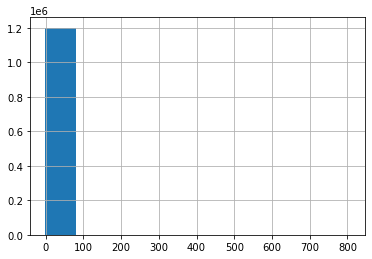

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
CHARGEOFF_WITHIN_12_MTHS

Первые пять строк:
index
0   -0.082301
1   -0.082301
2   -0.082301
3   -0.082301
4   -0.082301
Name: chargeoff_within_12_mths, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     3.429081e-06
std      9.970592e-01
min     -8.230142e-02
25%     -8.230142e-02
50%     -8.230142e-02
75%     -8.230142e-02
max      9.237763e+01
Name: chargeoff_within_12_mths, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.082301     1190259
 9.163692        8769
 18

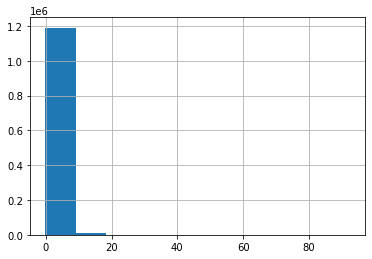

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
COLLECTIONS_12_MTHS_EX_MED

Первые пять строк:
index
0   -0.120093
1   -0.120093
2   -0.120093
3   -0.120093
4   -0.120093
Name: collections_12_mths_ex_med, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean    -2.337404e-06
std      9.944990e-01
min     -1.200935e-01
25%     -1.200935e-01
50%     -1.200935e-01
75%     -1.200935e-01
max      1.325665e+02
Name: collections_12_mths_ex_med, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.120093      1179983
 6.514236        1

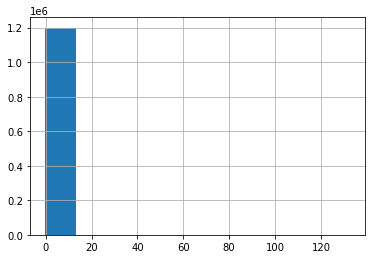

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
DELINQ_2YRS

Первые пять строк:
index
0   -0.358557
1   -0.358557
2    0.782501
3   -0.358557
4   -0.358557
Name: delinq_2yrs, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean    -4.095984e-06
std      9.991705e-01
min     -3.585568e-01
25%     -3.585568e-01
50%     -3.585568e-01
75%     -3.585568e-01
max      4.756588e+01
Name: delinq_2yrs, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.358557     971455
 0.782501     152036
 1.923559      44045
 3.064617      16219
 4

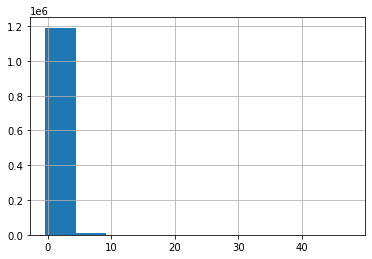

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
DTI

Первые пять строк:
index
0    1.481454
1   -1.313462
2   -0.085555
3   -1.218276
4   -0.556729
Name: dti, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean    -5.586271e-09
std      9.997286e-01
min     -2.265328e+00
25%     -7.494816e-01
50%     -5.818901e-02
75%      7.056834e-01
max      3.798058e+00
Name: dti, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
 0.138133    892
-0.147426    863
-0.432986    839
-0.004647    836
-0.290206    815
            ... 
 3.74451

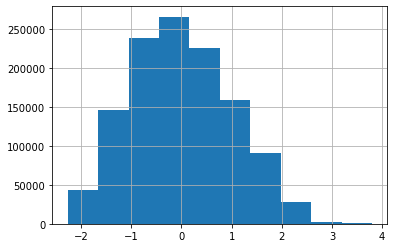

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
EMP_LENGTH

Первые пять строк:
index
0   -0.417197
1    1.141038
2   -0.676902
3   -1.456020
4   -1.456020
Name: emp_length, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     2.000555e-06
std      9.989884e-01
min     -1.456020e+00
25%     -9.366081e-01
50%     -1.574909e-01
75%      1.141038e+00
max      1.141038e+00
Name: emp_length, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
 1.141038    396909
-1.456020    166219
-0.936608    109330
-0.676902     96811
-1.196314

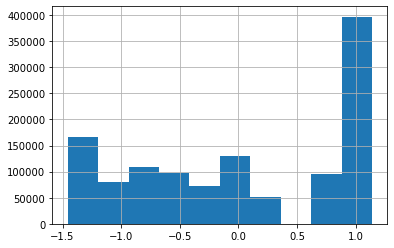

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
FICO_RANGE_HIGH

Первые пять строк:
index
0   -0.377219
1   -0.377219
2   -0.841039
3   -0.222612
4   -0.841039
Name: fico_range_high, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean    -6.879629e-07
std      1.000687e+00
min     -1.150253e+00
25%     -8.410392e-01
50%     -2.226116e-01
75%      5.504228e-01
max      4.601123e+00
Name: fico_range_high, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-1.150253    104274
-0.841039    101384
-0.995646    100855
-0.686432     

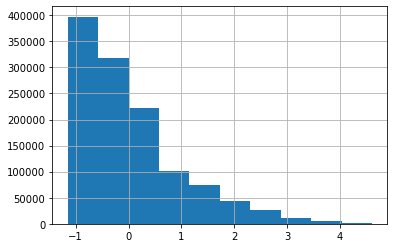

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
FICO_RANGE_LOW

Первые пять строк:
index
0   -0.377222
1   -0.377222
2   -0.841052
3   -0.222612
4   -0.841052
Name: fico_range_low, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean    -1.579081e-07
std      1.000688e+00
min     -1.150273e+00
25%     -8.410523e-01
50%     -2.226117e-01
75%      5.504390e-01
max      4.570303e+00
Name: fico_range_low, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-1.150273    104274
-0.841052    101384
-0.995662    100855
-0.686442     906

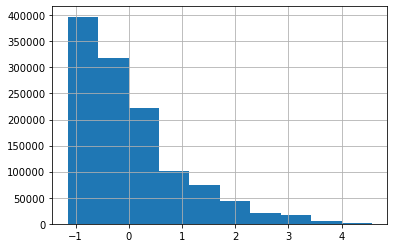

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
FUNDED_AMNT

Первые пять строк:
index
0    0.180130
1   -0.881392
2   -0.497437
3   -1.287932
4    0.631842
Name: funded_amnt, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean    -1.726476e-07
std      9.994997e-01
min     -1.570252e+00
25%     -7.599944e-01
50%     -2.715812e-01
75%      6.318421e-01
max      2.890400e+00
Name: funded_amnt, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.497437    94596
-0.271581    64097
 0.631842    63920
 0.067203    63154
-1.062077 

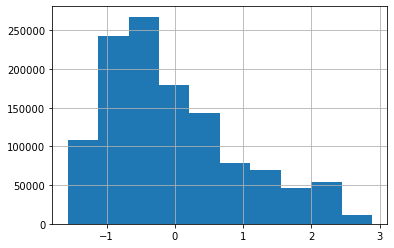

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
HOME_OWNERSHIP

Первые пять строк:
index
0    3.0
1    0.0
2    0.0
3    2.0
4    3.0
Name: home_ownership, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     1.426352e+00
std      1.421757e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      3.000000e+00
Name: home_ownership, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0.0    584268
3.0    481196
2.0    133423
1.0       937
Name: home_ownership, dtype: int64
-----------

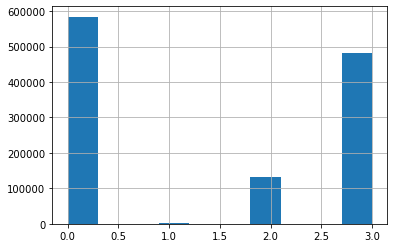

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
INQ_LAST_12M

Первые пять строк:
index
0   -0.071661
1   -0.549923
2   -0.549923
3   -0.549923
4   -0.549923
Name: inq_last_12m, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean    -7.782625e-07
std      9.999166e-01
min     -5.499235e-01
25%     -5.499235e-01
50%     -5.499235e-01
75%      4.066021e-01
max      2.288495e+01
Name: inq_last_12m, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.549923     731213
-0.071661     151569
 0.406602     111063
 0.884865      73983

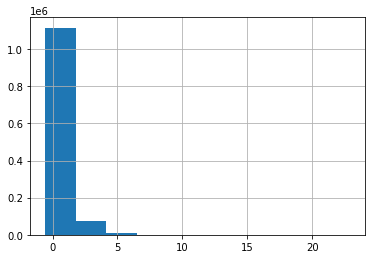

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
INSTALLMENT

Первые пять строк:
index
0    0.393433
1   -0.838661
2   -0.445276
3   -1.276055
4    0.633736
Name: installment, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean    -1.754303e-08
std      9.996452e-01
min     -1.632867e+00
25%     -7.233654e-01
50%     -2.464395e-01
75%      5.365750e-01
max      4.873221e+00
Name: installment, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.509050    2530
-0.409689    2246
-0.391630    2235
-0.280546    2028
 0.062229    1

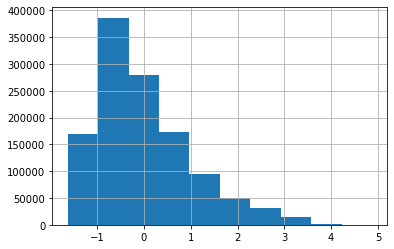

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
INT_RATE

Первые пять строк:
index
0   -0.030149
1   -0.566474
2   -0.864896
3   -0.334832
4    2.747472
Name: int_rate, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean    -3.254692e-09
std      9.994149e-01
min     -1.632864e+00
25%     -7.605527e-01
50%     -9.275498e-02
75%      5.959114e-01
max      3.726213e+00
Name: int_rate, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.447523    28586
-0.238836    27545
-1.630777    27417
 0.178538    25416
-0.343179    19940


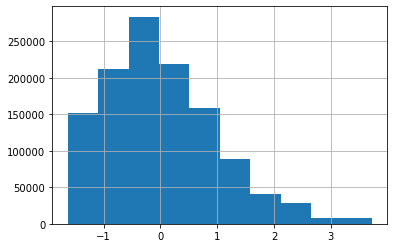

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
LOAN_AMNT

Первые пять строк:
index
0    0.179368
1   -0.881817
2   -0.497984
3   -1.288228
4    0.630936
Name: loan_amnt, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     1.621266e-07
std      9.990711e-01
min     -1.570458e+00
25%     -7.576359e-01
50%     -2.722002e-01
75%      6.309361e-01
max      2.888777e+00
Name: loan_amnt, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.497984    94654
-0.272200    64162
 0.630936    64045
 0.066476    63232
-1.062444    460

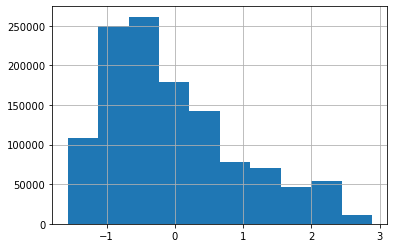

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
MORT_ACC

Первые пять строк:
index
0    1.745358
1    0.206104
2    0.719189
3   -0.820065
4   -0.820065
Name: mort_acc, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.168320e+06
mean    -9.220938e-07
std      1.002084e+00
min     -8.200647e-01
25%     -8.200647e-01
50%     -3.069802e-01
75%      7.191886e-01
max      3.047808e+01
Name: mort_acc, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.820065     486698
-0.306980     204887
 0.206104     170009
 0.719189     122486
 1.232273  

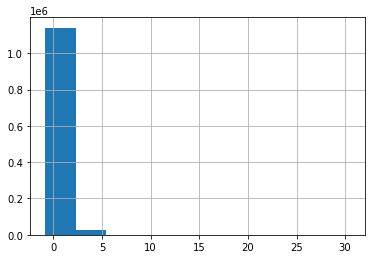

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
MTHS_SINCE_LAST_DELINQ

Первые пять строк:
index
0    1.430147
1   -0.736405
2   -0.303094
3   -0.736405
4    0.303540
Name: mths_since_last_delinq, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     1.101390e-06
std      1.000269e+00
min     -7.364046e-01
25%     -7.364046e-01
50%     -7.364046e-01
75%      6.068574e-01
max      9.056409e+00
Name: mths_since_last_delinq, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.736405    608769
-0.216432     11204
-0.476418    

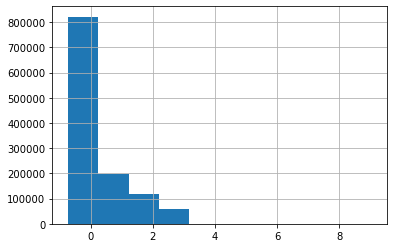

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
MTHS_SINCE_RECENT_BC_DLQ

Первые пять строк:
index
0    2.782199
1   -0.464034
2   -0.464034
3   -0.464034
4   -0.464034
Name: mths_since_recent_bc_dlq, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean    -3.678484e-06
std      9.972227e-01
min     -4.640337e-01
25%     -4.640337e-01
50%     -4.640337e-01
75%     -4.640337e-01
max      9.424490e+00
Name: mths_since_recent_bc_dlq, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.464034    917633
 0.784517      4360
 0.8344

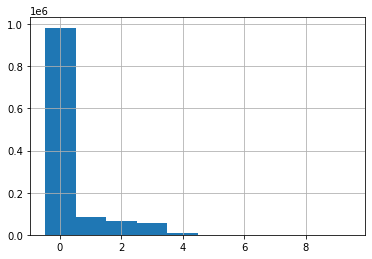

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
MTHS_SINCE_RECENT_INQ

Первые пять строк:
index
0    0.004199
1   -1.004251
2    1.180724
3    1.684949
4    1.516874
Name: mths_since_recent_inq, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     3.262487e-07
std      9.985580e-01
min     -1.004251e+00
25%     -8.361760e-01
50%     -3.319510e-01
75%      5.084240e-01
max      3.197624e+00
Name: mths_since_recent_inq, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-1.004251    243441
-0.836176    118139
-0.668101     94

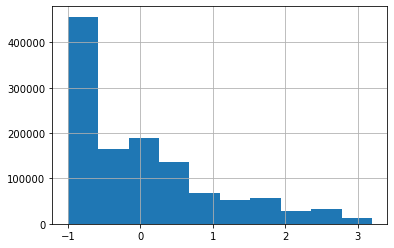

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
NUM_ACCTS_EVER_120_PD

Первые пять строк:
index
0    1.836753
1   -0.378444
2   -0.378444
3   -0.378444
4   -0.378444
Name: num_accts_ever_120_pd, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.154852e+06
mean    -9.441921e-07
std      9.968410e-01
min     -3.784445e-01
25%     -3.784445e-01
50%     -3.784445e-01
75%     -3.784445e-01
max      3.727991e+01
Name: num_accts_ever_120_pd, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.378444     883335
 0.359955     144907
 1.098354     

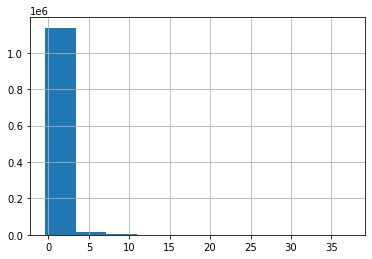

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
NUM_ACTV_BC_TL

Первые пять строк:
index
0    0.150735
1   -0.286853
2   -1.162027
3   -0.286853
4   -1.162027
Name: num_actv_bc_tl, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.154852e+06
mean    -4.292576e-07
std      9.992161e-01
min     -1.599615e+00
25%     -7.244400e-01
50%     -2.868527e-01
75%      5.883219e-01
max      2.027975e+01
Name: num_actv_bc_tl, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.286853     245180
-0.724440     235160
 0.150735     190042
-1.162027     

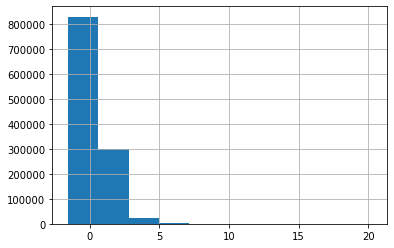

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
NUM_REV_ACCTS

Первые пять строк:
index
0    0.328949
1   -0.779816
2    1.068125
3   -0.410228
4   -1.395796
Name: num_rev_accts, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.154851e+06
mean    -3.549112e-08
std      1.000308e+00
min     -1.765384e+00
25%     -7.798157e-01
50%     -1.638355e-01
75%      4.521447e-01
max      1.400371e+01
Name: num_rev_accts, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.533424     69015
-0.656620     68212
-0.410228     67623
-0.779816     65706


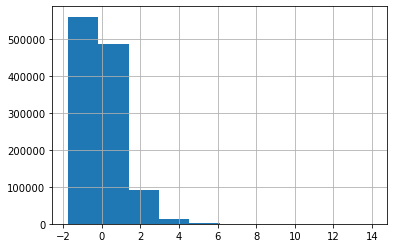

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
NUM_SATS

Первые пять строк:
index
0    0.421859
1   -1.190981
2   -0.832572
3    1.317881
4   -1.370185
Name: num_sats, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.162566e+06
mean    -4.783893e-07
std      9.998528e-01
min     -2.087003e+00
25%     -6.533676e-01
50%     -1.157544e-01
75%      4.218588e-01
max      1.404139e+01
Name: num_sats, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.474163     101919
-0.294959      98880
-0.653368      98313
-0.115754      91449
-0.832572  

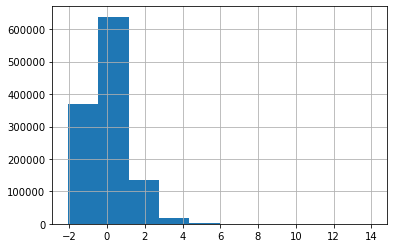

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
NUM_TL_120DPD_2M

Первые пять строк:
index
0   -0.024129
1   -0.024129
2   -0.024129
3   -0.024129
4   -0.024129
Name: num_tl_120dpd_2m, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean    -3.047852e-06
std      9.997144e-01
min     -2.412917e-02
25%     -2.412917e-02
50%     -2.412917e-02
75%     -2.412917e-02
max      2.168355e+02
Name: num_tl_120dpd_2m, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.024129      1199066
 36.119137         724
 72.262405          29
 1

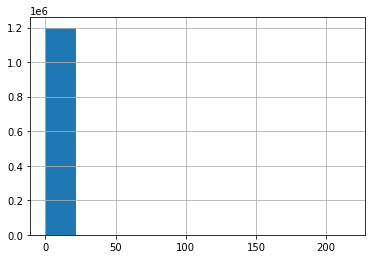

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
NUM_TL_30DPD

Первые пять строк:
index
0   -0.052818
1   -0.052818
2   -0.052818
3   -0.052818
4   -0.052818
Name: num_tl_30dpd, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.154852e+06
mean     3.026592e-06
std      9.986823e-01
min     -5.281753e-02
25%     -5.281753e-02
50%     -5.281753e-02
75%     -5.281753e-02
max      6.712387e+01
Name: num_tl_30dpd, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.052818     1151425
 16.741356       3251
 33.535530        150
 50.329700       

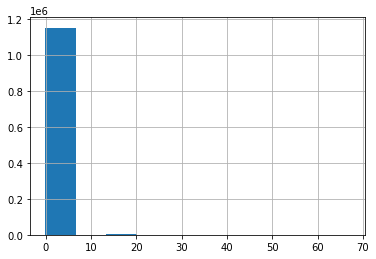

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
NUM_TL_90G_DPD_24M

Первые пять строк:
index
0   -0.172549
1   -0.172549
2   -0.172549
3   -0.172549
4   -0.172549
Name: num_tl_90g_dpd_24m, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.154852e+06
mean     2.214417e-06
std      9.926450e-01
min     -1.725492e-01
25%     -1.725492e-01
50%     -1.725492e-01
75%     -1.725492e-01
max      8.341837e+01
Name: num_tl_90g_dpd_24m, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.172549     1090514
 1.817711       48172
 3.807971        9495

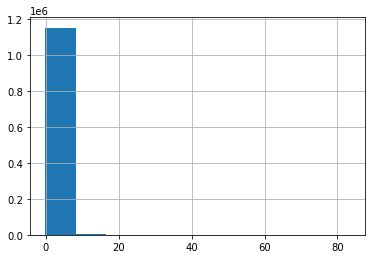

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
NUM_TL_OP_PAST_12M

Первые пять строк:
index
0    0.454769
1   -1.163409
2   -1.163409
3    0.994161
4   -1.163409
Name: num_tl_op_past_12m, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.154852e+06
mean    -1.363056e-06
std      9.993154e-01
min     -1.163409e+00
25%     -6.240166e-01
50%     -8.462402e-02
75%      4.547685e-01
max      1.609715e+01
Name: num_tl_op_past_12m, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.624017     287845
-0.084624     259067
-1.163409     201656
 0

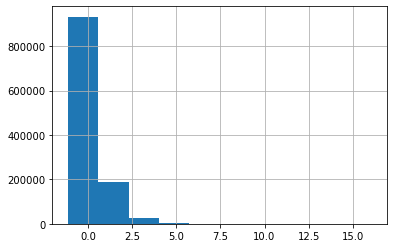

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
OPEN_ACC

Первые пять строк:
index
0    0.426901
1   -1.187522
2   -0.828761
3    1.323804
4   -1.366903
Name: open_acc, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean    -3.327773e-07
std      9.994427e-01
min     -2.084424e+00
25%     -6.493810e-01
50%     -1.112398e-01
75%      4.269015e-01
max      1.405981e+01
Name: open_acc, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.470001     105173
-0.290620     101920
-0.649381     101380
-0.111240      94237
-0.828761  

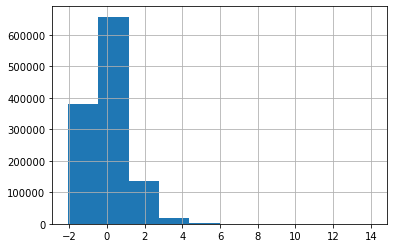

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
OPEN_IL_24M

Первые пять строк:
index
0    0.196454
1   -1.021726
2   -1.021726
3         NaN
4    0.805544
Name: open_il_24m, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    632647.000000
mean         -0.000001
std           0.999474
min          -1.021726
25%          -0.412636
50%          -0.412636
75%           0.196454
max          22.732780
Name: open_il_24m, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.412636     195526
-1.021726     155476
 0.196454     133866
 0.805544      

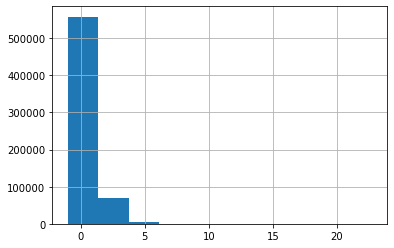

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
OPEN_RV_24M

Первые пять строк:
index
0    0.037740
1   -0.712027
2    0.037740
3         NaN
4   -0.712027
Name: open_rv_24m, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    632647.000000
mean         -0.000004
std           1.000378
min          -1.086911
25%          -0.712027
50%          -0.337143
75%           0.412624
max          19.156807
Name: open_rv_24m, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.712027     128900
-0.337143     120478
 0.037740      93807
-1.086911      

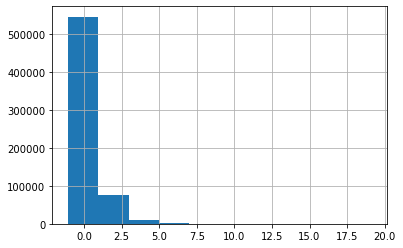

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
PERCENT_BC_GT_75

Первые пять строк:
index
0    1.605195
1    1.605195
2   -1.142958
3   -1.142958
4    1.605195
Name: percent_bc_gt_75, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     2.695848e-06
std      9.994583e-01
min     -1.142958e+00
25%     -1.142958e+00
50%     -2.278227e-01
75%      7.807494e-01
max      1.605195e+00
Name: percent_bc_gt_75, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-1.142958    349565
 1.605195    200288
 0.231119    124895
-0.227823  

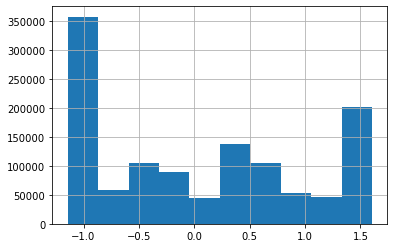

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
PUB_REC

Первые пять строк:
index
0    1.337271
1    1.337271
2   -0.354918
3   -0.354918
4   -0.354918
Name: pub_rec, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean    -5.116673e-07
std      9.997949e-01
min     -3.549184e-01
25%     -3.549184e-01
50%     -3.549184e-01
75%     -3.549184e-01
max      1.451734e+02
Name: pub_rec, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.354918      1000690
 1.337271       167886
 3.029461        20400
 4.721651         6271
 6.413

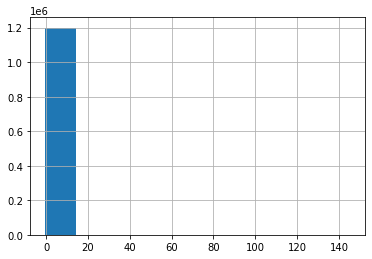

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
PUB_REC_BANKRUPTCIES

Первые пять строк:
index
0    2.323947
1    2.323947
2   -0.355332
3   -0.355332
4   -0.355332
Name: pub_rec_bankruptcies, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199392e+06
mean    -6.268197e-06
std      9.987419e-01
min     -3.553318e-01
25%     -3.553318e-01
50%     -3.553318e-01
75%     -3.553318e-01
max      3.179601e+01
Name: pub_rec_bankruptcies, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.355332     1051100
 2.323947      140093
 5.003226      

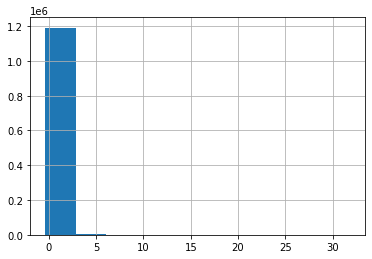

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
PURPOSE

Первые пять строк:
index
0    1.0
1    1.0
2    1.0
3    0.0
4    9.0
Name: purpose, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     2.715613e+00
std      2.410214e+00
min      0.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      1.300000e+01
Name: purpose, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
2.0     684517
1.0     268411
4.0      78964
9.0      73214
6.0      26885
7.0      14327
11.0     13458
0.0      13213
12.

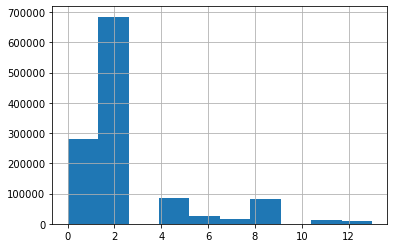

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
REVOL_UTIL

Первые пять строк:
index
0    0.221672
1    1.524573
2   -1.315912
3   -0.696832
4    1.536712
Name: revol_util, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     4.542724e-08
std      9.997354e-01
min     -2.048288e+00
25%     -7.575263e-01
50%      3.173413e-03
75%      7.719657e-01
max      3.405663e+01
Name: revol_util, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-2.048288    6611
 0.003173    2503
 0.258089    2356
-0.106076    2342
 0.298552    2318

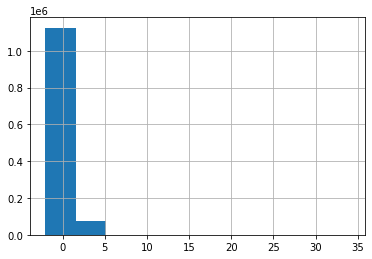

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
TAX_LIENS

Первые пять строк:
index
0   -0.129437
1   -0.129437
2   -0.129437
3   -0.129437
4   -0.129437
Name: tax_liens, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean    -9.698764e-07
std      9.969527e-01
min     -1.294374e-01
25%     -1.294374e-01
50%     -1.294374e-01
75%     -1.294374e-01
max      2.170370e+02
Name: tax_liens, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.129437      1162613
 2.425461        25221
 4.980360         6918
 7.535259         2535


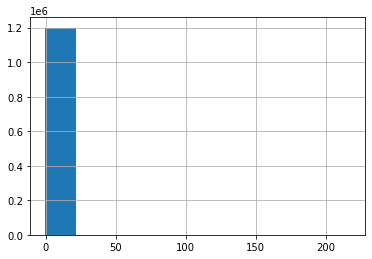

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
TERM

Первые пять строк:
index
0    36.0
1    36.0
2    36.0
3    36.0
4    60.0
Name: term, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     4.192411e+01
std      1.031624e+01
min      3.600000e+01
25%      3.600000e+01
50%      3.600000e+01
75%      3.600000e+01
max      6.000000e+01
Name: term, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
36.0    903662
60.0    296162
Name: term, dtype: int64
------------------------------------------------------------------------

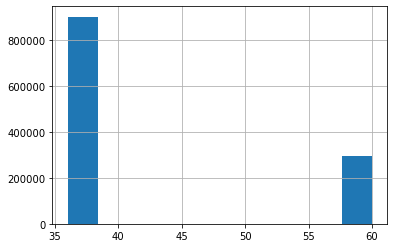

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
TOTAL_ACC

Первые пять строк:
index
0    0.112631
1   -1.131950
2    0.527492
3   -0.053313
4   -0.717090
Name: total_acc, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     1.968444e-08
std      9.990168e-01
min     -1.878699e+00
25%     -7.170895e-01
50%     -1.362849e-01
75%      5.274919e-01
max      1.230953e+01
Name: total_acc, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.385201     43733
-0.302229     43191
-0.468173     43069
-0.551145     42875
-0.219257   

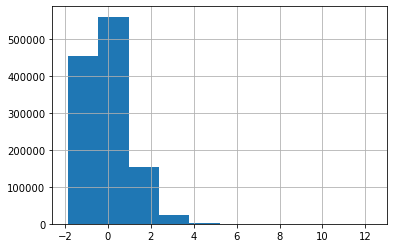

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
VERIFICATION_STATUS

Первые пять строк:
index
0    1.0
1    0.0
2    1.0
3    1.0
4    0.0
Name: verification_status, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     6.857072e-01
std      4.624159e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: verification_status, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
1.0    822728
0.0    377096
Name: verification_status, dtype: int64
-------------------

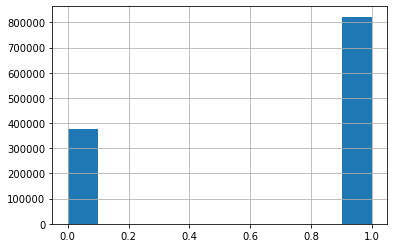

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
TIME_IN

Первые пять строк:
index
0    0.377360
1    0.839393
2   -0.148864
3   -1.329693
4   -0.299112
Name: time_in, dtype: float32
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    1.199824e+06
mean     1.410314e-07
std      9.997519e-01
min     -2.703800e+00
25%     -6.856682e-01
50%     -1.703780e-01
75%      5.170283e-01
max      8.568747e+00
Name: time_in, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
-0.513552    8114
-0.642639    8056
-0.245150    7923
-0.373884    7826
-0.502619    7741
        

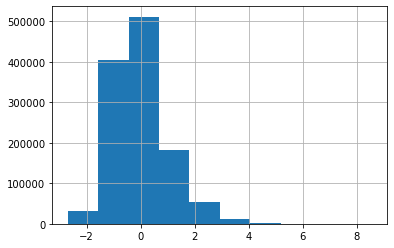

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [114]:
for _ in X_test.columns:
    feat_info(X_train, _)

In [112]:
result = pd.DataFrame({'loan_status' : best_model_lgbm.predict_proba(X_test)[:,1]})
result.to_csv('data/answer.csv', index_label='index')

In [113]:
a = pd.read_csv('data/answer.csv')
a

,index,loan_status
0,0,0.823837
1,1,0.592017
2,2,0.431488
3,3,0.129936
4,4,0.259928
...,...,...
590972,590972,0.301993
590973,590973,0.522739
590974,590974,0.596293
590975,590975,0.189912
